In [1]:
import numpy as np
import pandas as pd

from scipy.stats import trim_mean   # conda install scipy
from statsmodels import robust      # conda install -c conda-forge statsmodels 
import wquantiles                   # pip install wquantiles

import matplotlib.pylab as plt
import seaborn as sns

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

from sklearn import linear_model
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
df_city = pd.read_csv('../../data/diamonds_city_202208201409.csv')
df_clarity = pd.read_csv('../../data/diamonds_clarity_202208201409.csv')
df_color = pd.read_csv('../../data/diamonds_color_202208201409.csv')
df_cut = pd.read_csv('../../data/diamonds_cut_202208201409.csv')
df_dimensions = pd.read_csv('../../data/diamonds_dimensions_202208201409.csv')
df_properties = pd.read_csv('../../data/diamonds_properties_202208201409.csv')
df_transactional = pd.read_csv('../../data/diamonds_transactional_202208201409.csv')

In [3]:
df_diamonds = df_properties.merge(
    df_clarity, on="clarity_id", how="left").merge(
    df_color, on="color_id", how="left").merge(
    df_cut, on="cut_id", how="left").merge(
    df_dimensions, on="index_id", how="left").merge(
    df_transactional, on="index_id", how="left").merge(df_city, on="city_id", how="left")

In [4]:
#reordenamos el orden de las columnas
df_diamonds_features = df_diamonds[['carat','depth','table','x', 'y', 'z', 'city', 'cut', 'color','clarity']]
df_diamonds_price = df_diamonds['price']
#df_diamonds_features
#df_diamonds_price

### Categorical Data

In [5]:
cols = ['city', 'cut', 'color', 'clarity']

cat_list = []
for col in cols:
    cat = df_diamonds_features[col].unique()
    cat_num = len(cat)
    cat_dict = {"categorical_variable":col,
                "number_of_possible_values":cat_num,
                "values":cat}
    cat_list.append(cat_dict)
    
categories = pd.DataFrame(cat_list).sort_values(by="number_of_possible_values",
                                                ascending=False).reset_index(drop=True)
categories

,categorical_variable,number_of_possible_values,values
0,city,13,"[Kimberly, Antwerp, London, New York City, Dub..."
1,clarity,8,"[VS2, VS1, SI1, SI2, IF, VVS1, VVS2, I1]"
2,color,7,"[J, H, G, D, F, E, I]"
3,cut,5,"[Premium, Very Good, Fair, Good, Ideal]"


In [6]:
df_diamonds_mix = df_diamonds_features.copy()

### Drops

In [7]:
#df_diamonds_mix.drop('city', axis=1, inplace=True)

### Mix Label and Dummies

In [8]:
# Usando tanto get.dummies como label encoding con Cut (Fair, Good, Very Good, Premium, Ideal), 
         # Color from J (worst) to D (best) y Claridad (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best)).

In [9]:
# Label encoding y get.dummies con el resto
encoding_cut = {'Fair':1, 'Good':2, 'Very Good':3, 'Premium':4, 'Ideal':5}
def ordinal_encoding_cut(x):
    for key in encoding_cut:
        if x == key:
            return encoding_cut[key]

In [10]:
encoding_color = {'J':1, 'I':2, 'H':3, 'G':4, 'F':5, 'E':6, 'D':7}
def ordinal_encoding_color(x):
    for key in encoding_color:
        if x == key:
            return encoding_color[key]

In [11]:
encoding_clarity = {'I1':1, 'SI2':2, 'SI1':3, 'VS2':4, 'VS1':5, 'VVS2':6, 'VVS1':7, 'IF':8}
def ordinal_encoding_clarity(x):
    for key in encoding_clarity:
        if x == key:
            return encoding_clarity[key]

### Labeling 0 (seems to be all RMSE 1128 and Random Forest 640 with MinMax dropping or not x,y,z)

In [86]:
df_diam_mix_0 = pd.get_dummies(df_diamonds_mix, columns=['cut', 'color', 'clarity', 'city'], drop_first=True)

### Labeling 1 (seems to be all RMSE 1159 and Random Forest 638 with MinMax Cut)

In [12]:
# cut
df_diam_mix_cut = df_diamonds_mix.copy()

In [13]:
df_diam_mix_cut['cut'] = df_diam_mix_cut['cut'].apply(ordinal_encoding_cut)

In [14]:
df_diam_mix_cut = pd.get_dummies(df_diam_mix_cut, columns=['color', 'clarity', 'city'], drop_first=True)

In [15]:
# color
df_diam_mix_color = df_diamonds_mix.copy()

In [16]:
df_diam_mix_color['color'] = df_diam_mix_color['color'].apply(ordinal_encoding_color)

In [17]:
df_diam_mix_color = pd.get_dummies(df_diam_mix_color, columns=['cut', 'clarity', 'city'], drop_first=True)

In [18]:
# clarity
df_diam_mix_clarity = df_diamonds_mix.copy()

In [19]:
df_diam_mix_clarity['clarity'] = df_diam_mix_clarity['clarity'].apply(ordinal_encoding_clarity)

In [20]:
df_diam_mix_clarity = pd.get_dummies(df_diam_mix_clarity, columns=['cut', 'clarity', 'city'], drop_first=True)

### Labeling 2 (seems to be all RMSE 1180 and Random Forest 630 with MinMax CC)

In [21]:
#Label cut & color

df_d_m_cc = df_diamonds_mix.copy()

In [22]:
df_d_m_cc['cut'] = df_d_m_cc['cut'].apply(ordinal_encoding_cut)
df_d_m_cc['color'] = df_d_m_cc['color'].apply(ordinal_encoding_color)

In [23]:
df_d_m_cc = pd.get_dummies(df_d_m_cc, columns=['clarity', 'city'], drop_first=True)

In [24]:
#Label clarity & color

df_d_m_clc = df_diamonds_mix.copy()

In [25]:
df_d_m_clc['clarity'] = df_d_m_clc['clarity'].apply(ordinal_encoding_clarity)
df_d_m_clc['color'] = df_d_m_clc['color'].apply(ordinal_encoding_color)

In [26]:
df_d_m_clc = pd.get_dummies(df_d_m_clc, columns=['cut', 'city'], drop_first=True)

In [27]:
#Label clarity & cut

df_d_m_clcu = df_diamonds_mix.copy()

In [28]:
df_d_m_clcu['clarity'] = df_d_m_clcu['clarity'].apply(ordinal_encoding_clarity)
df_d_m_clcu['cut'] = df_d_m_clcu['cut'].apply(ordinal_encoding_cut)

In [29]:
df_d_m_clcu = pd.get_dummies(df_d_m_clcu, columns=['color', 'city'], drop_first=True)

### Label 3 (seems to be all RMSE Linear 1219 and Random Forest 549 with MinMax CC)

In [68]:
#Label clarity & cut & color

df_d_m_clcuco = df_diamonds_mix.copy()

In [69]:
df_d_m_clcuco['cut'] = df_d_m_clcuco['cut'].apply(ordinal_encoding_cut)
df_d_m_clcuco['color'] = df_d_m_clcuco['color'].apply(ordinal_encoding_color)
df_d_m_clcuco['clarity'] = df_d_m_clcuco['clarity'].apply(ordinal_encoding_clarity)

In [71]:
df_d_m_clcuco = pd.get_dummies(df_d_m_clcuco, columns=['city'], drop_first=True)

### Escalado Mix

## Scale cut

In [87]:
df_diam_mix_0_cols = list(df_diam_mix_0.columns)
df_d_m_clc_cols = list(df_d_m_clc.columns)
df_d_m_clcu_cols = list(df_d_m_clcu.columns)

In [88]:
# Using scikit-learn .StandardScaler() Label and dumm

scaler_stand = StandardScaler()
df_diam_mix_0_stand = scaler_stand.fit_transform(df_diam_mix_0)
df_diam_mix_0_stand = pd.DataFrame(df_diam_mix_0_stand, columns=df_diam_mix_0_cols)
#df_diam_mix_cut_stand

In [89]:
# Using scikit-learn .MinMaxScaler()

scaler_minmax = MinMaxScaler()
df_diam_mix_0_minmax = scaler_minmax.fit_transform(df_diam_mix_0)
df_diam_mix_0_minmax = pd.DataFrame(df_diam_mix_0_minmax, columns=df_diam_mix_0_cols)
#df_diamonds_mix_minmax

In [90]:
# Using scikit-learn .Robust()

scaler_robust = RobustScaler()
df_diam_mix_0_rob = scaler_robust.fit_transform(df_diam_mix_0)
df_diam_mix_0_rob = pd.DataFrame(df_diam_mix_0_rob, columns=df_diam_mix_0_cols)
#df_diamonds_mix_rob

In [ ]:
# Cada caso con un tipo de escaler

# Caso 1: Sin eliminar nada
# Caso 2: Eliminar posibles columnas: columnas de la original o columnas que se han ido incluyendo.
# Caso 3: Eliminar posibles filas: como por ejemplo en las que X, Y y Z valen 0
# Caso 4: eliminando outliers

# Case 2. Delete Columns Mix

In [ ]:
#list(df_d_m_clcuco_stand.columns)
#list(df_d_m_clcuco_minmax.columns)
#list(df_d_m_clcuco_rob.columns)

In [ ]:
df_diam_mix_0_stand_corr = df_diam_mix_0_stand.corr()
df_diam_mix_0_minmax_corr = df_diam_mix_0_minmax.corr()
df_diam_mix_0_rob_corr = df_diam_mix_0_rob.corr()
#df_diamonds_mix_corr

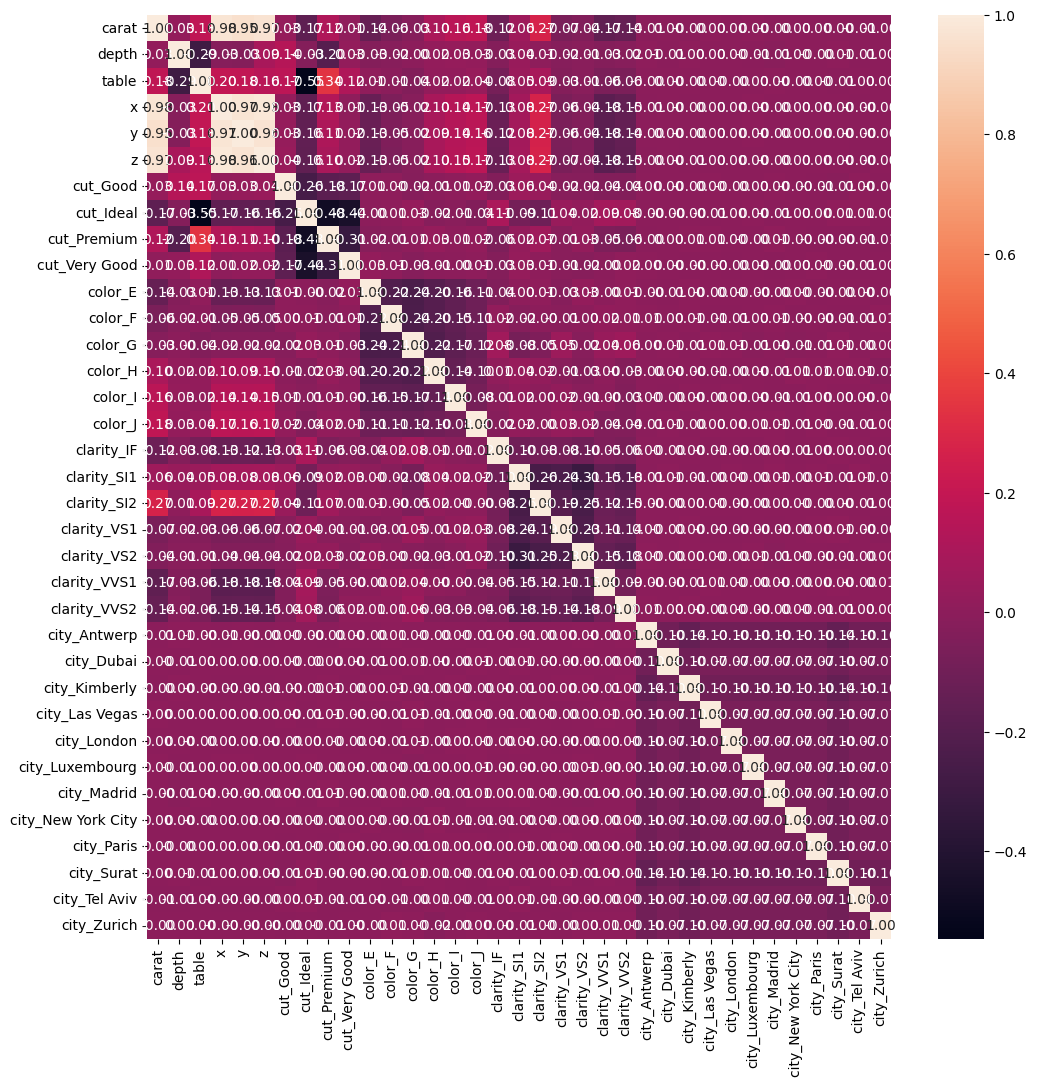

In [91]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1, 1, 1)
sns.heatmap(df_diam_mix_0_stand.corr(method='pearson'), annot=True, fmt='.2f', ax=ax);
#sns.heatmap(df_diam_mix_cut_minmax.corr(method='pearson'), annot=True, fmt='.2f', ax=ax);
#sns.heatmap(df_diam_mix_cut_rob.corr(method='pearson'), annot=True, fmt='.2f', ax=ax);

In [113]:
df_diam_mix_0_stand_uncorr = df_diam_mix_0_stand.drop(['x', 'y', 'z'], axis=1)
df_diam_mix_0_minmax_uncorr = df_diam_mix_0_minmax.drop(['x', 'y', 'z'], axis=1)
df_diam_mix_0_rob_uncorr = df_diam_mix_0_rob.drop(['x', 'y', 'z'], axis=1)

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.heatmap(df_diam_mix_cut_stand_uncorr.corr(), annot=True, vmin=-1, vmax=1)
#ax = sns.heatmap(df_diam_mix_cut_minmax_uncorr.corr(), annot=True, vmin=-1, vmax=1)
#ax = sns.heatmap(df_diam_mix_cut_rob_uncorr.corr(), annot=True, vmin=-1, vmax=1)

# Case 3

In [6]:
case3 = df_diamonds_features.copy()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_10168\3685564164.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case3_num['volum'] = case3_num['x']*case3_num['y']*case3_num['z']
C:\Users\Usuario\AppData\Local\Temp\ipykernel_10168\3685564164.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case3_num.drop(['x', 'y', 'z'], axis=1, inplace=True)


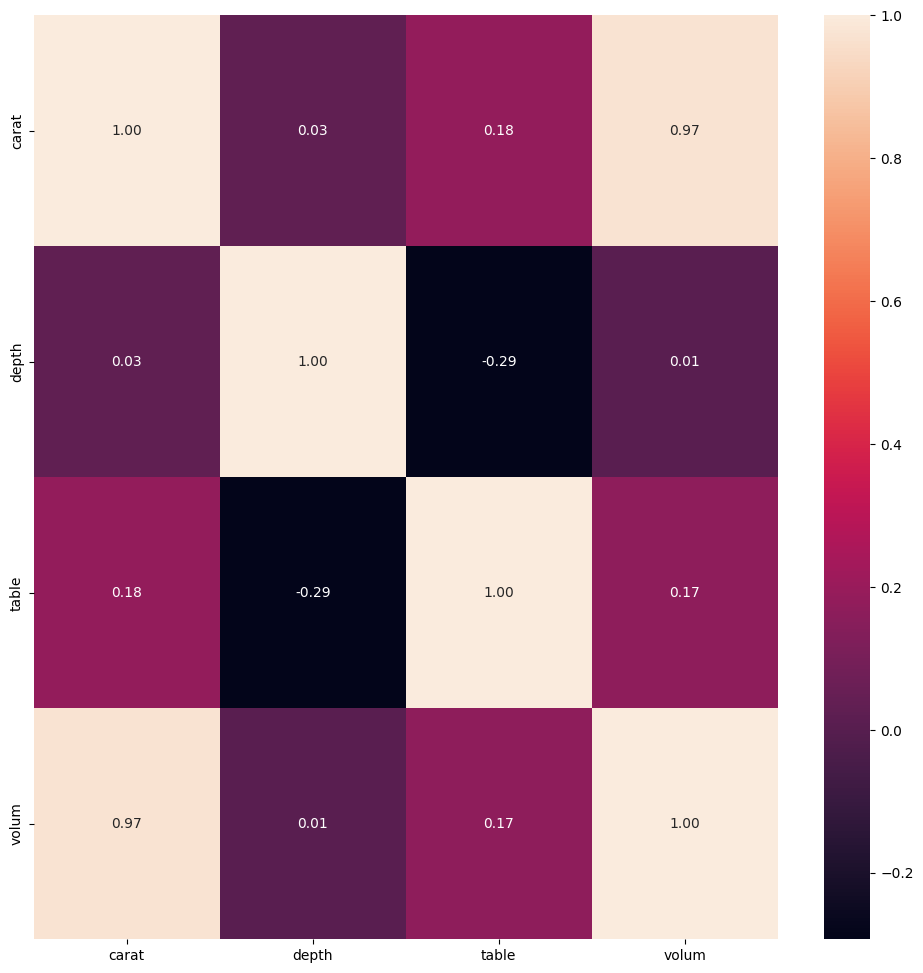

In [14]:
#case3.info()
case3_cat = case3[['city', 'cut', 'color', 'clarity']]
case3_num = case3[['carat', 'depth', 'table', 'x', 'y', 'z']]
case3_num['volum'] = case3_num['x']*case3_num['y']*case3_num['z']
case3_num.drop(['x', 'y', 'z'], axis=1, inplace=True)

In [17]:
case3_num_cols = list(case3_num.columns)
scaler_minmax = MinMaxScaler()
case3_num_minmax = scaler_minmax.fit_transform(case3_num)
case3_num_minmax = pd.DataFrame(case3_num_minmax, columns=case3_num_cols)

In [19]:
case3_cat.drop(['city'], axis=1, inplace=True)
case3_cat = pd.get_dummies(case3_cat, columns=['cut', 'color', 'clarity'], drop_first=True)
#case3_cat

C:\Users\Usuario\AppData\Local\Temp\ipykernel_10168\1154560540.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case3_cat.drop(['city'], axis=1, inplace=True)


,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40450,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
40451,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
40452,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
40453,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0


In [20]:
result = pd.concat([case3_num_minmax, case3_cat], axis=1)
#result

,carat,depth,table,volum,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.234884,0.538889,0.288462,0.051319,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
1,0.027907,0.555556,0.269231,0.013643,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
2,0.118605,0.625000,0.230769,0.029536,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0.048837,0.577778,0.250000,0.017255,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0.190698,0.486111,0.307692,0.043855,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40450,0.265116,0.547222,0.269231,0.057655,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
40451,0.423256,0.391667,0.326923,0.084434,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
40452,0.188372,0.547222,0.250000,0.042699,0,1,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
40453,0.030233,0.525000,0.217308,0.014295,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


In [ ]:
trainers = [df_diam_mix_0_stand, df_diam_mix_0_minmax, df_diam_mix_0_rob]

In [26]:
X = list(result.columns)
X_1 = result[X]
y = df_diamonds_price
x_train, x_test, y_train, y_test = train_test_split(X_1, y, test_size=0.2, random_state=42)
model = linear_model.Lasso()
#model = ElasticNet()
#model = Ridge()
#model = SVR()
#model = SGDRegressor()
#model = LinearRegression()
model.fit(x_train, y_train)
predictions = model.predict(x_test)
rmse = mean_squared_error(predictions,  y_test, squared=False)
rmse

1156.0396656313728

In [22]:
regressor = RandomForestRegressor(random_state = 42)
#regressor = GradientBoostingRegressor(random_state = 42)
#regressor = LinearRegression()

hyperparameters = regressor.get_params()
#print('Model hyperparameters:', hyperparameters, '\n')
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)
rmse = mean_squared_error(y_pred, y_test, squared=False)
rmse

641.7956182874626

In [102]:
# Cross Validation

scores = cross_val_score(regressor, 
                         X_1, 
                         y, 
                         scoring='neg_root_mean_squared_error', 
                         cv=5,
                         n_jobs=1)
print(scores, '\n')
print(np.mean(-scores), '\n')

[-660.0079716  -671.28327517 -669.85543972 -664.11982381 -646.0124348 ] 

662.2557890194433 



In [ ]:
# Model definition

#model = linear_model.Lasso()
#model = ElasticNet()
#model = Ridge()
#model = SVR()
#model = SGDRegressor()
model = LinearRegression()


hyperparameters = model.get_params()

#print(type(model), '\n')
#print('Model hyperparameters:', hyperparameters, '\n')

# Model training

model.fit(x_train_mix_stand, y_train_mix_stand)

#print('Model:', model, '\n')
#print('Model hyperparameters:', hyperparameters, '\n')
# print('Model coefficients:', model.coef_, '\n')

predictions = model.predict(x_test_mix_stand)

# RMSE calculation

rmse = mean_squared_error(predictions,  y_test_mix_stand, squared=False)
rmse

# Test

In [ ]:
df_test = pd.read_csv('../../data/diamonds_test.csv')
df_test.drop('id', axis=1, inplace=True)
#df_test

### Mix

In [ ]:
df_test_mix = df_test.copy()

In [ ]:
df_test_mix['cut'] = df_test_mix['cut'].apply(ordinal_encoding_cut)
#df_test_mix['color'] = df_test_mix['color'].apply(ordinal_encoding_color)
#df_test_mix['clarity'] = df_test_mix['clarity'].apply(ordinal_encoding_clarity)
#df_test_mix

In [ ]:
df_test_mix.drop('city', axis=1, inplace=True)

In [ ]:
df_test_mix = pd.get_dummies(df_test_mix, columns=['color', 'clarity'], drop_first=True)

In [ ]:
df_test_cols_mix = list(df_test_mix.columns)

In [ ]:
# Using scikit-learn .StandardScaler() Label and dumm

scaler_stand = StandardScaler()
df_diamonds_mix_stand = scaler_stand.fit_transform(df_test_mix)
df_diamonds_mix_stand = pd.DataFrame(df_diamonds_mix_stand, columns=df_test_cols_mix)
df_diamonds_mix_stand

In [ ]:
# Using scikit-learn .MinMaxScaler()

scaler_minmax = MinMaxScaler()
df_diamonds_mix_minmax = scaler_minmax.fit_transform(df_test_mix)
df_diamonds_mix_minmax = pd.DataFrame(df_diamonds_mix_minmax, columns=df_cols_mix)
#df_diamonds_mix_minmax

In [ ]:
#df_diamonds_mix_stand.drop(['x', 'y', 'z'], axis=1, inplace=True)
df_diamonds_mix_minmax.drop(['x', 'y', 'z'], axis=1, inplace=True)

In [ ]:
#y_pred_test = regressor.predict(df_diamonds_mix_stand)
y_pred_test = regressor.predict(df_diamonds_mix_minmax)

In [ ]:
solucion = pd.DataFrame(y_pred_test, columns = ['Price'])
solucion.index.names = ['id']
solucion
solucion.to_csv('../../data/results.csv')